# Notebook to extract hidden-states and attention heads activations from bert model predictions

In [4]:
import os
import glob
import torch
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import BertExtractor
from sklearn.preprocessing import StandardScaler
from tokenizer import tokenize
from utils import set_seed
from numpy import linalg as la


In [5]:
def check_folder(path):
    """Create adequate folders if necessary."""
    try:
        if not os.path.isdir(path):
            check_folder(os.path.dirname(path))
            os.mkdir(path)
    except:
        pass

In [6]:
def transform(activations, path, name, run_index, n_layers_hidden=13, n_layers_attention=12, hidden_size=768):
    assert activations.values.shape[1] == (n_layers_hidden + n_layers_attention) * hidden_size
    indexes = [[index*hidden_size, (index+1)*hidden_size] for index in range(n_layers_hidden + n_layers_attention)]
    for order in [None]:
        matrices = []
        for index in indexes:
            matrix = activations.values[:, index[0]:index[1]]
            with_std = True if order=='std' else False
            scaler = StandardScaler(with_mean=True, with_std=with_std)
            scaler.fit(matrix)
            matrix = scaler.transform(matrix)
            if order is not None and order != 'std':
                matrix = matrix / np.mean(la.norm(matrix, ord=order, axis=1))
            matrices.append(matrix)
        matrices = np.hstack(matrices)
        new_data = pd.DataFrame(matrices, columns=activations.columns)
        new_path = path + '_norm-' + str(order).replace('np.', '')
        check_folder(new_path)
        new_data.to_csv(os.path.join(new_path, name + '_run{}.csv'.format(run_index + 1)), index=False)


Defining variables:

In [7]:
template = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/text_english_run*.txt' # path to text input
language = 'english'

Creating iterator for each run:

In [8]:
#template = '/Users/alexpsq/Code/Parietal/data/text_english_run*.txt' # path to text input


In [9]:
paths = sorted(glob.glob(template))

In [10]:
iterator_list = [tokenize(path, language, train=False) for path in paths]

100%|██████████| 207/207 [00:00<00:00, 838051.09it/s]


[10, 15, 16, 16, 16, 17, 17, 18, 19, 20, 20, 22, 22, 22, 23, 24, 24, 24, 25, 25, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 31, 32, 32, 32, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 37, 38, 39, 39, 39, 39, 39, 39, 40, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 43, 44, 44, 44, 45, 45, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 48, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 52, 54, 54, 55, 56, 56, 56, 56, 57, 57, 57, 58, 59, 59, 59, 60, 61, 61, 63, 63, 63, 63, 64, 66, 67, 68, 71, 71, 73, 80, 81, 83]


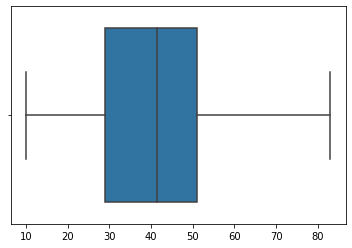


[12, 14, 20, 22, 22, 22, 22, 23, 23, 24, 24, 25, 25, 25, 26, 28, 28, 28, 28, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 38, 39, 39, 40, 40, 41, 42, 42, 43, 43, 43, 43, 44, 44, 44, 45, 45, 46, 46, 46, 47, 47, 48, 48, 48, 49, 50, 51, 51, 51, 51, 51, 52, 53, 53, 54, 54, 55, 56, 56, 57, 57, 58, 58, 58, 60, 60, 61, 61, 61, 61, 62, 62, 62, 64, 64, 65, 66, 66, 66, 67, 68, 69, 69, 69, 70, 71, 72, 73, 76, 76, 76, 76, 78, 80, 81, 92, 96, 98]


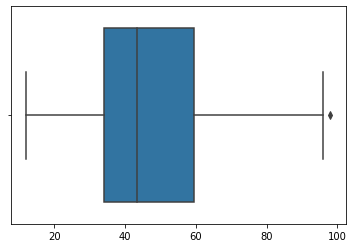


[17, 17, 18, 18, 18, 19, 19, 19, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 39, 39, 39, 40, 40, 40, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 45, 45, 45, 45, 46, 46, 47, 47, 47, 49, 49, 50, 51, 51, 52, 53, 54, 55, 55, 55, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 63, 65, 66, 67, 67, 68, 71, 71, 71, 72, 73, 74, 76, 77, 79, 82, 95, 102, 108]


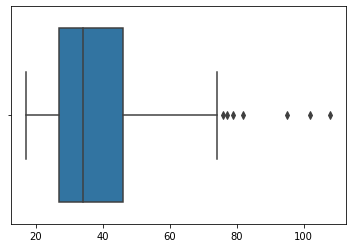


[10, 10, 11, 13, 13, 14, 15, 15, 16, 16, 16, 17, 18, 19, 19, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 33, 33, 34, 34, 34, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 51, 51, 52, 53, 53, 53, 53, 55, 55, 56, 58, 58, 59, 59, 60, 61, 61, 62, 63, 65, 65, 66, 67, 67, 68, 72, 91, 95]


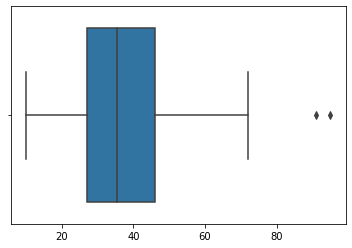


[9, 10, 11, 12, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 36, 36, 36, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 42, 43, 43, 43, 43, 44, 44, 45, 45, 45, 46, 47, 47, 47, 47, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 54, 55, 55, 57, 58, 58, 60, 60, 61, 61, 61, 62, 67, 72, 74, 79]


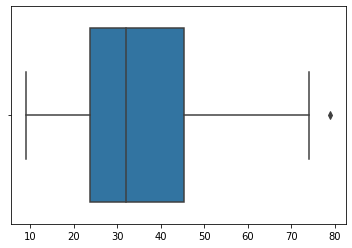


[10, 10, 10, 11, 12, 12, 13, 13, 13, 14, 14, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 48, 49, 49, 49, 50, 51, 51, 52, 53, 53, 54, 54, 54, 55, 56, 57, 57, 62, 64, 66, 67, 71, 76, 81, 125, 125]


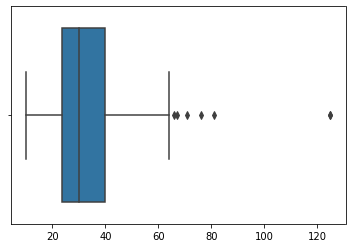


[10, 11, 14, 14, 14, 15, 15, 16, 16, 17, 17, 18, 19, 19, 19, 19, 19, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 47, 48, 48, 48, 48, 48, 48, 50, 50, 52, 52, 54, 54, 54, 54, 56, 56, 58, 60, 60, 61, 61, 66, 67, 68, 68, 70, 72, 76, 83, 99, 111, 114, 115]


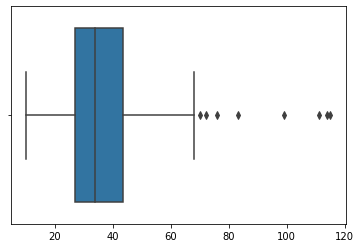


[14, 14, 14, 16, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 22, 24, 24, 24, 25, 25, 26, 26, 27, 27, 27, 28, 28, 28, 28, 29, 29, 30, 30, 30, 30, 30, 31, 31, 32, 32, 32, 32, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 41, 41, 41, 41, 42, 42, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 46, 47, 47, 49, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 54, 54, 55, 55, 57, 57, 57, 58, 59, 59, 60, 60, 62, 62, 62, 63, 63, 64, 65, 67, 73, 76, 77, 81, 82, 85, 89, 89, 107, 110, 134]


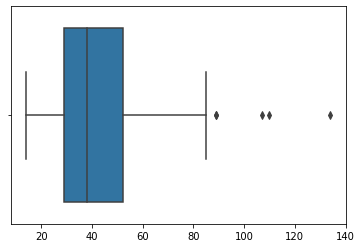


[13, 14, 15, 18, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 47, 47, 48, 49, 49, 49, 49, 50, 50, 51, 51, 53, 54, 54, 54, 54, 55, 55, 55, 56, 58, 59, 59, 60, 60, 60, 60, 60, 61, 62, 63, 63, 67, 67, 68, 69, 69, 72, 85, 85, 89]


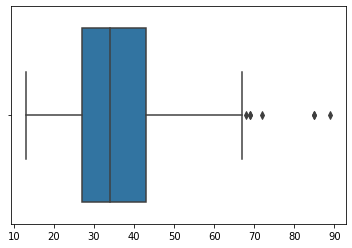

In [21]:
import utils
import seaborn as sns
import matplotlib.pyplot as plt

for index in range(9):
    batches, indexes = utils.batchify_per_sentence_with_pre_and_post_context(
                iterator_list[index], 
                1, 
                2, 
                0, 
                'bert-base-uncased', 
                max_length=512)
    print(sorted([len(item.split()) for item in batches]))
    sns.boxplot(sorted([len(item.split()) for item in batches]))
    plt.show()
    print()

[2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 20, 20, 20, 21, 21, 22, 22, 22, 22, 23, 24, 24, 25, 25, 25, 26, 26, 27, 29, 29, 30, 31, 32, 33, 34, 34, 36, 38, 38, 45]


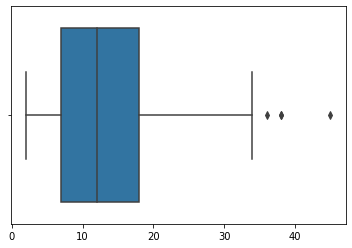


[2, 2, 3, 3, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 23, 25, 25, 25, 25, 26, 26, 28, 29, 29, 29, 32, 32, 34, 34, 35, 37, 38, 39, 41, 43, 47, 48]


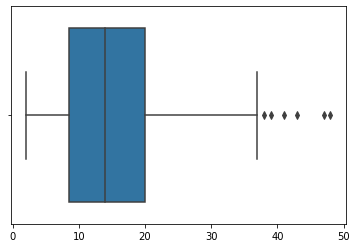


[2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 22, 22, 22, 23, 23, 24, 25, 25, 26, 26, 26, 27, 27, 28, 28, 29, 29, 31, 32, 32, 37, 38, 39, 40, 40, 49, 49]


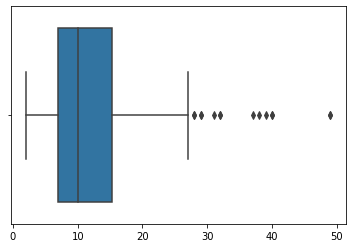


[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24, 24, 25, 27, 27, 28, 33, 34, 35, 35, 37, 38, 45, 49, 55]


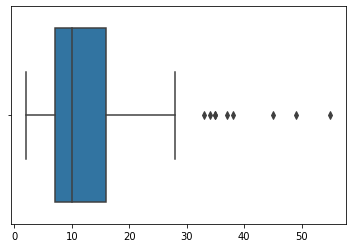


[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 24, 25, 25, 26, 26, 27, 28, 29, 31, 34, 35, 49]


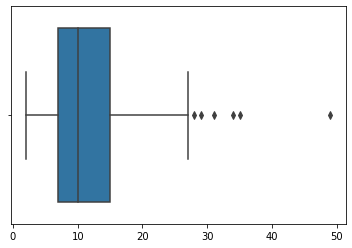


[1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 21, 21, 21, 21, 21, 22, 23, 23, 24, 25, 26, 26, 27, 27, 27, 27, 28, 35, 37, 40, 57, 58]


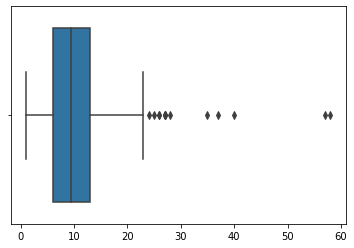


[3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 22, 22, 22, 22, 22, 26, 26, 28, 30, 30, 30, 32, 32, 33, 34, 89]


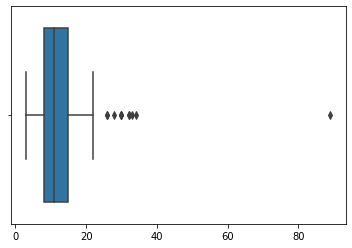


[2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 26, 27, 27, 29, 32, 33, 35, 39, 40, 42, 45, 60, 61]


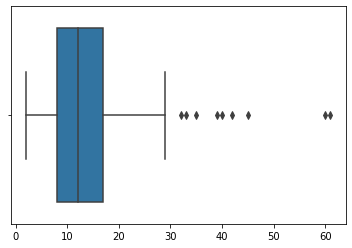


[2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 26, 27, 27, 27, 28, 31, 36, 37, 39, 42, 45]


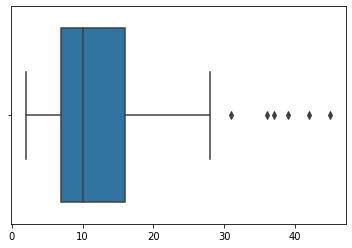

In [20]:
for index in range(9):
    batches, indexes = utils.batchify_per_sentence_with_pre_and_post_context(
                iterator_list[index], 
                1, 
                0, 
                0, 
                'bert-base-uncased', 
                max_length=512)
    print(sorted([len(item.split()) for item in batches]))
    sns.boxplot(sorted([len(item.split()) for item in batches]))
    plt.show()
    print()

## Activation extraction

In [15]:
pretrained_bert_models = ['bert-base-uncased'] * 11
names = [
    'bert-base-uncased_token_1-sent-0-0',
    'bert-base-uncased_token_1-sent-1-0',
    'bert-base-uncased_token_1-sent-2-0',
    'bert-base-uncased_token_1-sent-5-0',
    'bert-base-uncased_token_1-sent-7-0',
    'bert-base-uncased_token_1-sent-10-0',
    'bert-base-uncased_token_1-sent-15-0',
    'bert-base-uncased_token_1-sent-20-0',
    'bert-base-uncased_token_1-sent-30-0',
    'bert-base-uncased_token_1-sent-40-0',
    'bert-base-uncased_token_1-sent-1000-0',
         ]
config_paths = [None] * 11
saving_path_folders = [
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-0-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-1-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-2-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-5-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-7-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-10-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-15-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-20-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-30-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-40-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_token_1-sent-1000-0'.format(language),
]
prediction_types = ['token-level'] * 11
number_of_sentence_list = [1] * 11
number_of_sentence_before_list = [0] * 11 # 0, 1, 2, 5, 7, 10,
number_of_sentence_after_list = [0] * 11
attention_length_before_list = [0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 1000]
attention_length_after_list = [0] * 11 



In [ ]:
for index, bert_model in enumerate(pretrained_bert_models):
    extractor = BertExtractor(bert_model, 
                              language, 
                              names[index], 
                              prediction_types[index], 
                              output_hidden_states=True, 
                              output_attentions=True, 
                              attention_length_before=attention_length_before_list[index],
                              attention_length_after=attention_length_after_list[index],
                              config_path=config_paths[index], 
                              max_length=512, 
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index], 
                              number_of_sentence_after=number_of_sentence_after_list[index])
    print(extractor.name, ' - Extracting activations ...')
    for run_index, iterator in tqdm(enumerate(iterator_list)):
        gc.collect()
        print("############# Run {} #############".format(run_index))
        activations  = extractor.extract_activations(iterator, language)
        hidden_states_activations = activations[0]
        attention_heads_activations = activations[1]
        #(cls_hidden_states_activations, cls_attention_activations) = activations[2]
        #(sep_hidden_states_activations, sep_attention_activations) = activations[3]
        activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
        #cls_activations = pd.concat([cls_hidden_states_activations, cls_attention_activations], axis=1)
        #sep_activations = pd.concat([sep_hidden_states_activations, sep_attention_activations], axis=1)
        
        transform(
            activations, 
            saving_path_folders[index], 
            'activations', 
            run_index=run_index,
            n_layers_hidden=13,
            n_layers_attention=12, 
            hidden_size=768)
        #transform(cls_activations, saving_path_folders[index], 'cls')
        #transform(sep_activations, saving_path_folders[index], 'sep')
        
        #activations.to_csv(os.path.join(saving_path_folders[index], 'activations_run{}.csv'.format(run_index + 1)), index=False)
        #cls_activations.to_csv(os.path.join(saving_path_folders[index], 'cls_run{}.csv'.format(run_index + 1)), index=False)
        #sep_activations.to_csv(os.path.join(saving_path_folders[index], 'sep_run{}.csv'.format(run_index + 1)), index=False)
        del activations
        #del cls_activations
        #del sep_activations
        del hidden_states_activations
        del attention_heads_activations
        #del cls_hidden_states_activations
        #del cls_attention_activations
        #del sep_hidden_states_activations
        #del sep_attention_activations
        


0it [00:00, ?it/s]

bert-base-uncased_token-1000-1  - Extracting activations ...
############# Run 0 #############



1it [02:44, 164.47s/it]

############# Run 1 #############



2it [06:22, 180.65s/it]

############# Run 2 #############



3it [10:12, 195.40s/it]

############# Run 3 #############



4it [12:59, 186.89s/it]

############# Run 4 #############



5it [16:04, 186.34s/it]

############# Run 5 #############



6it [19:53, 199.07s/it]

############# Run 6 #############



7it [23:05, 197.00s/it]

############# Run 7 #############



8it [26:26, 198.23s/it]

############# Run 8 #############



9it [30:20, 202.27s/it]

0it [00:00, ?it/s]

bert-base-uncased_token-1000-5  - Extracting activations ...
############# Run 0 #############



1it [02:44, 164.22s/it]

############# Run 1 #############



2it [06:17, 178.79s/it]

############# Run 2 #############



3it [10:06, 194.00s/it]

############# Run 3 #############



4it [13:02, 188.68s/it]

############# Run 4 #############



5it [15:58, 184.81s/it]

############# Run 5 #############



6it [20:19, 207.66s/it]

############# Run 6 #############



7it [24:06, 213.60s/it]

############# Run 7 #############



8it [27:09, 204.16s/it]

############# Run 8 #############



9it [31:03, 207.03s/it]

0it [00:00, ?it/s]

bert-base-uncased_token-1000-10  - Extracting activations ...
############# Run 0 #############


### Generate control activations

In [76]:
bert_model = 'bert-base-cased'
language = 'english'
name = 'bert-base-cased_control_'
prediction_type = 'sentence'
saving_path_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}'.format(language)
seeds = [24, 213, 1111, 61, 183]

In [77]:
def randomize_layer(model, layer_nb):
    """Randomize layer weights and put bias to zero.
    The input "layer_nb" goes from 1 to 12 to be coherent with the rest of the analysis.
    It is then transfomed in the function.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.query.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.query.weight))
    model.encoder.layer[layer_nb].attention.self.query.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.query.bias))
    model.encoder.layer[layer_nb].attention.self.key.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.key.weight))
    model.encoder.layer[layer_nb].attention.self.key.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.key.bias))
    model.encoder.layer[layer_nb].attention.self.value.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.value.weight))
    model.encoder.layer[layer_nb].attention.self.value.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.value.bias))
    model.encoder.layer[layer_nb].attention.output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.dense.weight))
    model.encoder.layer[layer_nb].attention.output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.dense.bias))
    model.encoder.layer[layer_nb].attention.output.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.LayerNorm.weight))
    model.encoder.layer[layer_nb].attention.output.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.LayerNorm.bias))
    model.encoder.layer[layer_nb].intermediate.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].intermediate.dense.weight))
    model.encoder.layer[layer_nb].intermediate.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].intermediate.dense.bias))
    model.encoder.layer[layer_nb].output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.dense.weight))
    model.encoder.layer[layer_nb].output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.dense.bias))
    model.encoder.layer[layer_nb].output.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.LayerNorm.weight))
    model.encoder.layer[layer_nb].output.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.LayerNorm.bias))
    return model

In [78]:
def randomize_attention_query(model, layer_nb):
    """Randomize attention query weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.query.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.query.weight))
    model.encoder.layer[layer_nb].attention.self.query.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.query.bias))
    return model

def randomize_attention_key(model, layer_nb):
    """Randomize attention key weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.key.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.key.weight))
    model.encoder.layer[layer_nb].attention.self.key.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.key.bias))
    return model

def randomize_attention_value(model, layer_nb):
    """Randomize attention value weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.value.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.value.weight))
    model.encoder.layer[layer_nb].attention.self.value.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.value.bias))
    return model

def randomize_attention_output_dense(model, layer_nb):
    """Randomize attention dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.dense.weight))
    model.encoder.layer[layer_nb].attention.output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.dense.bias))
    return model


def randomize_intermediate_dense(model, layer_nb):
    """Randomize intermediate dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].intermediate.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].intermediate.dense.weight))
    model.encoder.layer[layer_nb].intermediate.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].intermediate.dense.bias))
    return model

def randomize_outptut_dense(model, layer_nb):
    """Randomize output dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.dense.weight))
    model.encoder.layer[layer_nb].output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.dense.bias))
    return model


In [79]:
def randomize_embeddings(model):
    """Randomize embeddings weights and put bias to zero.
    """
    model.embeddings.word_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.word_embeddings.weight))
    model.embeddings.position_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.position_embeddings.weight))
    model.embeddings.token_type_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.token_type_embeddings.weight))
    model.embeddings.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.LayerNorm.weight))
    model.embeddings.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.embeddings.LayerNorm.bias))
    return model

In [80]:
for seed in seeds:
    set_seed(seed)
    for layer in range(13):
        extractor = BertExtractor(bert_model, language, name, prediction_type, output_hidden_states=True, output_attentions=True, config_path=None)
        if layer==0:
            extractor.model = randomize_embeddings(extractor.model)
        else:
            extractor.model = randomize_layer(extractor.model, layer)
        print(extractor.name + str(seed), ' - Extracting activations for layer {}...'.format(layer))
        for run_index, iterator in tqdm(enumerate(iterator_list)):
            print("############# Run {} #############".format(run_index))
            activations  = extractor.extract_activations(iterator, language)
            hidden_states_activations = activations[0]
            attention_heads_activations = activations[1]
            (cls_hidden_states_activations, cls_attention_activations) = activations[2]
            (sep_hidden_states_activations, sep_attention_activations) = activations[3]
            activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
            cls_activations = pd.concat([cls_hidden_states_activations, cls_attention_activations], axis=1)
            sep_activations = pd.concat([sep_hidden_states_activations, sep_attention_activations], axis=1)

            # activations
            heads = np.arange(1, 13)
            columns_to_retrieve = ['hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            activations = activations[columns_to_retrieve]

            # CLS
            heads = np.arange(1, 13)
            columns_to_retrieve = ['CLS-hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['CLS-attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            cls_activations = cls_activations[columns_to_retrieve]

            # SEP
            heads = np.arange(1, 13)
            columns_to_retrieve = ['SEP-hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['SEP-attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            sep_activations = sep_activations[columns_to_retrieve]

            save_path = os.path.join(saving_path_folder, name + str(seed) + '_layer-{}'.format(layer))
            check_folder(save_path)
            print('\tSaving in {}.'.format(save_path))
            activations.to_csv(os.path.join(save_path, 'activations_run{}.csv'.format(run_index + 1)), index=False)
            cls_activations.to_csv(os.path.join(save_path, 'cls_run{}.csv'.format(run_index + 1)), index=False)
            sep_activations.to_csv(os.path.join(save_path, 'sep_run{}.csv'.format(run_index + 1)), index=False)


0it [00:00, ?it/s]

bert-base-cased  - Extracting activations for layer 0...
############# Run 0 #############


1it [00:23, 23.37s/it]

############# Run 1 #############


2it [00:50, 24.54s/it]

############# Run 2 #############


3it [01:23, 26.94s/it]

############# Run 3 #############


3it [01:44, 34.92s/it]


KeyboardInterrupt: 